<a href="https://colab.research.google.com/github/danielh325/FII-NX3Intl-Eunchan-Hwang/blob/main/FII_NX3Intl_Eunchan_Hwang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense
from keras.models import Model
from tensorflow.keras import layers, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import glob
import random
import re
import random
from IPython.display import Image
import matplotlib.cm as cm
import kagglehub
import tensorflow as tf
import tensorflow.keras.preprocessing.image

In [ ]:
#create helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import plot_loss_curves, walk_through_dir, make_confusion_matrix

--2025-09-13 23:02:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-09-13 23:02:06 (97.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
#Importing Training Data
path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

print("Path:",path)

Using Colab cache for faster access to the 'tuberculosis-tb-chest-xray-dataset' dataset.
Path: /kaggle/input/tuberculosis-tb-chest-xray-dataset


In [ ]:
df_norm = pd.read_excel(f'{path}/TB_Chest_Radiography_Database/Normal.metadata.xlsx')
df_tb = pd.read_excel(f'{path}/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx')

In [ ]:
print('Normal metadata:', df_norm.shape)
print('TB metadata: ', df_tb.shape)

Normal metadata: (3500, 4)
TB metadata:  (700, 4)


In [ ]:
df_norm.head()

,FILE NAME,FORMAT,SIZE,URL
0,Normal-1,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1,Normal-2,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
2,Normal-3,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
3,Normal-4,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
4,Normal-5,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...


In [ ]:
df_tb.head()

,FILE NAME,FORMAT,SIZE,URL
0,Tuberculosis-1,PNG,512*512,http://tuberculosis.by/
1,Tuberculosis-2,PNG,512*512,http://tuberculosis.by/
2,Tuberculosis-3,PNG,512*512,http://tuberculosis.by/
3,Tuberculosis-4,PNG,512*512,http://tuberculosis.by/
4,Tuberculosis-5,PNG,512*512,http://tuberculosis.by/


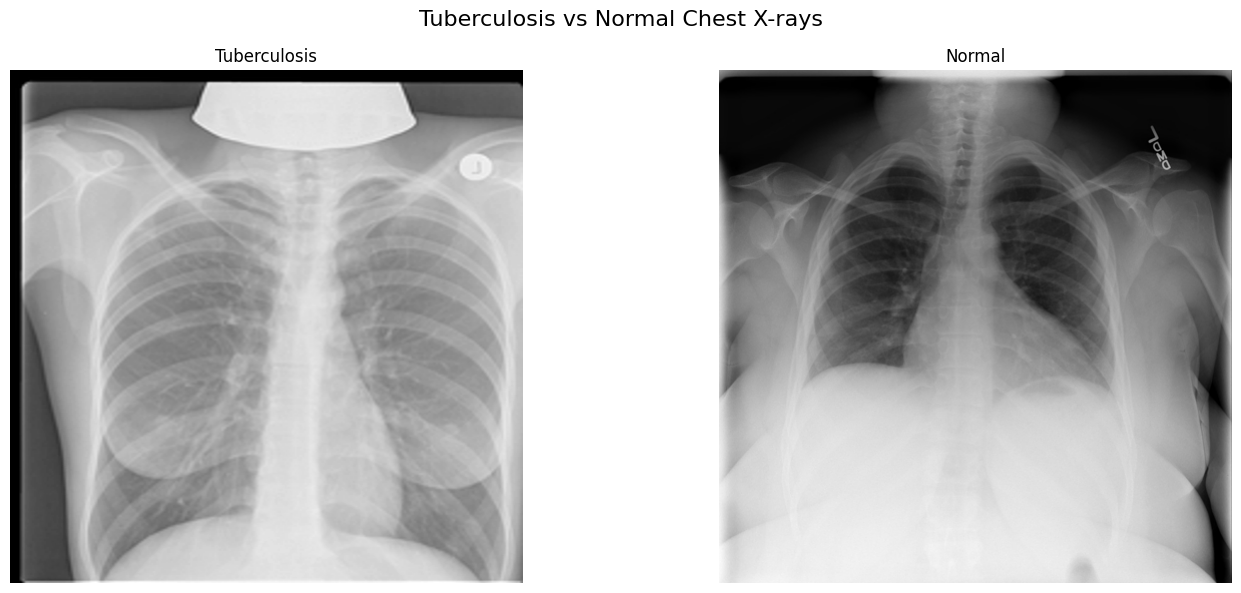

In [ ]:
#Creating Data Frame for Norm vs. TB
from PIL import Image
labels = ['Tuberculosis','Normal']
data_path = f"{path}/TB_Chest_Radiography_Database"

def get_sample_images(label, num_samples=4):
    image_files = os.listdir(os.path.join(data_path, label))[num_samples:]
    image_paths = [os.path.join(data_path, label, img) for img in image_files]
    return image_paths

tb_images = get_sample_images(labels[0])
normal_images = get_sample_images(labels[1])
i = random.randint(0,100)

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Tuberculosis vs Normal Chest X-rays", fontsize=16)

# Tuberculosis images
axes[0].set_title("Tuberculosis")
img_tb = Image.open(tb_images[i])
axes[0].imshow(img_tb, cmap='gray')
axes[0].axis("off")

# Normal images
axes[1].set_title("Normal")
img_normal = Image.open(normal_images[i])
axes[1].imshow(img_normal, cmap='gray')
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
#Dataframe with Image & Label for TB
df_norm['Tuberculosis'] = float(0)
df_tb['Tuberculosis'] = float(1)
df_norm.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df_tb.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df = pd.concat([df_norm, df_tb])
df = df.sample(frac=1).reset_index(drop=True)
df.rename(columns = {'FILE NAME':'Image'}, inplace = True)
label = ['Tuberculosis']

In [ ]:
df.head()

,Image,Tuberculosis
0,Normal-2259,0.0
1,Tuberculosis-139,1.0
2,Normal-1713,0.0
3,Normal-2199,0.0
4,Normal-2275,0.0


In [ ]:
#Diving for Training/Validation/Testing
ds = f"{path}/TB_Chest_Radiography_Database"
walk_through_dir(ds)

SOURCE_PATH_NORM = os.path.join(ds, 'Normal')
SOURCE_PATH_TB = os.path.join(ds, 'Tuberculosis')

print(f"There are {len(os.listdir(SOURCE_PATH_NORM))} images of Normal.")
print(f"There are {len(os.listdir(SOURCE_PATH_TB))} images of Tuberculosis.")

There are 2 directories and 3 images in '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'.
There are 0 directories and 700 images in '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis'.
There are 0 directories and 3500 images in '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal'.
There are 3500 images of Normal.
There are 700 images of Tuberculosis.


In [ ]:
def create_img_train_val_test_dirs(root_path):
  train_dir = os.path.join(root_path,'training')
  val_dir = os.path.join(root_path, 'validation')
  test_dir = os.path.join(root_path,'testing')
  os.makedirs(train_dir + '/Normal')
  os.makedirs(train_dir + '/Tuberculosis')
  os.makedirs(val_dir + '/Normal')
  os.makedirs(val_dir + '/Tuberculosis')
  os.makedirs(test_dir + '/Normal')
  os.makedirs(test_dir + '/Tuberculosis')
  os.makedirs(root_path + '/Images')
create_img_train_val_test_dirs('./')

FileExistsError: [Errno 17] File exists: './training/Normal'

In [ ]:
# Map train validation test directories
IMAGE_DIR = os.path.join('./', 'Images')

TRAINING_DIR = "./training"
VAL_DIR = "./validation"
TESTING_DIR = "./testing"

TRAINING_NORM_DIR = os.path.join(TRAINING_DIR, "Normal/")
VAL_NORM_DIR = os.path.join(VAL_DIR, "Normal/")
TESTING_NORM_DIR = os.path.join(TESTING_DIR, "Normal/")

TRAINING_TB_DIR = os.path.join(TRAINING_DIR, "Tuberculosis/")
VAL_TB_DIR = os.path.join(VAL_DIR, "Tuberculosis/")
TESTING_TB_DIR = os.path.join(TESTING_DIR, "Tuberculosis/")

In [ ]:
#Spliting Data by 80%/10%/10% Ratio
def split_data(SOURCE, TRAINING, VAL, TESTING, SPLIT_SIZE_TRAIN = 0.8, SPLIT_SIZE_VAL = 0.1):

  zero_dir = [fn for fn in os.listdir(SOURCE) if os.path.getsize(os.path.join(SOURCE, fn)) == 0]
  for fn in zero_dir :
    print(fn,'is zero length, so ignoring.')

  use_dir = [fn for fn in os.listdir(SOURCE) if fn not in zero_dir]
  random.seed(2)
  train_dt = random.sample(use_dir, np.int64(SPLIT_SIZE_TRAIN * len(use_dir)))
  test_dt = [fn for fn in use_dir if fn not in train_dt]
  val_dt = random.sample(test_dt, np.int64(SPLIT_SIZE_VAL * len(use_dir)))
  test_dt = [fn for fn in test_dt if fn not in val_dt]
  for fn in train_dt :
    shutil.copy(os.path.join(SOURCE, fn), TRAINING)
  for fn in val_dt :
    shutil.copy(os.path.join(SOURCE, fn), VAL)
  for fn in test_dt:
    shutil.copy(os.path.join(SOURCE, fn), TESTING)


split_data(SOURCE_PATH_NORM, TRAINING_NORM_DIR, VAL_NORM_DIR,  TESTING_NORM_DIR)
split_data(SOURCE_PATH_TB, TRAINING_TB_DIR, VAL_TB_DIR,  TESTING_TB_DIR)

In [ ]:
#Copying Data into each Dir
def images_copy(SOURCE_N, SOURCE_TB, IMAGE_DIR ):

    zero_dir = [fn for fn in os.listdir(SOURCE_N) if os.path.getsize(os.path.join(SOURCE_N, fn)) == 0]
    zero_dir.append([fn for fn in os.listdir(SOURCE_TB) if os.path.getsize(os.path.join(SOURCE_TB, fn)) == 0])

    for fn in zero_dir :
        print(fn,'is zero length, so ignoring.')

    use_dir_n = [fn for fn in os.listdir(SOURCE_N) if fn not in zero_dir]
    use_dir_tb = [fn for fn in os.listdir(SOURCE_TB) if fn not in zero_dir]
    random.seed(2)

    for fn in use_dir_n :
        shutil.copy(os.path.join(SOURCE_N, fn), IMAGE_DIR)
    for fn in use_dir_tb :
        shutil.copy(os.path.join(SOURCE_TB, fn), IMAGE_DIR)

images_copy(SOURCE_PATH_NORM, SOURCE_PATH_TB, IMAGE_DIR )

[] is zero length, so ignoring.


In [ ]:
len(os.listdir(IMAGE_DIR))

4200

In [ ]:
# create df_train, df_val, df_test
def create_df(NORM_DIR, TB_DIR , df ):
    df_fn_n = os.listdir(NORM_DIR)
    df_fn_tb = os.listdir(TB_DIR)
    df_fn = df_fn_n + df_fn_tb
    df_ext = []
    for fn in df_fn:
        df_ext.append(fn[:-4])
    df_res = df[df['Image'].isin(df_ext)]

    return df_res

In [ ]:
train_df = create_df(TRAINING_NORM_DIR, TRAINING_TB_DIR ,df )
val_df = create_df(VAL_NORM_DIR, VAL_TB_DIR, df)
test_df = create_df(TESTING_NORM_DIR, TESTING_TB_DIR, df)

In [ ]:
# add .png as suffix in Filename column since our images name has .png as suffix also
train_df['Image'] = train_df['Image'] + '.png'
val_df['Image'] = val_df['Image'] + '.png'
test_df['Image'] = test_df['Image'] + '.png'

/tmp/ipython-input-2220988174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Image'] = train_df['Image'] + '.png'
/tmp/ipython-input-2220988174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Image'] = val_df['Image'] + '.png'
/tmp/ipython-input-2220988174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [ ]:
import glob
train_norm = glob.glob(TRAINING_NORM_DIR +'/*.png')
train_tb = glob.glob(TRAINING_TB_DIR + '/*.png')

In [ ]:
def get_train_generator(df, image_dir, x_col, y_col, shuffle=True, batch_size=8, seed=1, target_w = 224, target_h = 224):
    # x_col (str): filenames / y_col (list): labels

    print("getting train generator...")
    # normalize each image using batch statistic
    image_generator = ImageDataGenerator()
    train_generator = image_generator.flow_from_dataframe(dataframe=df,directory=image_dir,x_col=x_col,y_col=y_col,class_mode="raw",batch_size=batch_size,shuffle=shuffle,seed=seed,target_size=(target_w,target_h))

    return train_generator

In [ ]:
def get_test_and_valid_generator(val_df, test_df, train_df, image_dir, x_col, y_col, sample_size=100, batch_size=8, seed=1, target_w = 224, target_h = 224):

    print("getting val and test generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
            dataframe=train_df,
            directory=image_dir,
            x_col= 'Image',
            y_col= 'Tuberculosis',
            class_mode="raw",
            batch_size=sample_size,
            shuffle=True,
            seed=seed,
            target_size=(target_w,target_h))

    # get data sample
    batch = next(raw_train_generator)
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator()
    image_generator.fit(data_sample)

    # get val and test generator
    val_generator = image_generator.flow_from_dataframe(
            dataframe=val_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    return val_generator, test_generator

In [ ]:
#Image Generator
train_generator = get_train_generator(train_df, IMAGE_DIR, 'Image', 'Tuberculosis')
val_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, 'Image', 'Tuberculosis')

getting train generator...
Found 3360 validated image filenames.
getting val and test generators...
Found 3360 validated image filenames.
Found 420 validated image filenames.
Found 420 validated image filenames.


In [ ]:
# Count the number of files in directories
train_tb = len(os.listdir(TRAINING_TB_DIR))
train_norm = len(os.listdir(TRAINING_NORM_DIR))

print('Percent of Tuberculosis/Normal: {:.2f}%'.format(100 * train_tb / train_norm))

Percent of Tuberculosis/Normal: 20.00%


In [ ]:
# Calculate positive and negative frequencies
freq_pos = round(train_tb / (train_tb + train_norm), 2)
freq_neg = 1 - freq_pos

In [ ]:
# Calculate weights
pos_weights = tf.constant(freq_neg, dtype=tf.float32)
neg_weights = tf.constant(freq_pos, dtype=tf.float32)

# Calculate contributions for debugging or validation (optional)
pos_contribution = freq_pos * pos_weights.numpy()
neg_contribution = freq_neg * neg_weights.numpy()

In [ ]:
print(f"Positive Contribution: {pos_contribution}")
print(f"Negative Contribution: {neg_contribution}")

Positive Contribution: 0.14110000431537628
Negative Contribution: 0.14110000431537628


In [ ]:
# Define weighted BCE loss function
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

        # Calculate weighted loss
        loss = tf.reduce_mean(
            -(pos_weights * y_true * tf.math.log(y_pred) +
              neg_weights * (1 - y_true) * tf.math.log(1 - y_pred))
        )
        return loss
    return weighted_loss

In [ ]:
#Prepocessing image for Keras
preprocess = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Normalization(
        mean=[0.485, 0.456, 0.406],
        variance=[0.229**2, 0.224**2, 0.225**2],
    ),
], name="preprocess")

In [ ]:
#DenseNet121 Baseline Model (No domain generalization)
IMG_SIZE = 224
def build_densenet121_basic(pos_weights=0.5, neg_weights=0.5):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = preprocess(inputs)
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False
    x = base_model(x, training=False)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=get_weighted_loss(pos_weights, neg_weights),
        metrics=["accuracy", tf.keras.metrics.AUC(name="auroc")]
    )
    return model

model1 = build_densenet121_basic(pos_weights=0.5, neg_weights=0.5)
model1.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
#MC, ALR, ES - Callbacks During Training
checkpoint_path = "/kaggle/working/Checkpoints/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

MC = ModelCheckpoint(filepath= checkpoint_path, verbose =2, save_weights_only=True )
RLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 2, min_lr =0.001)
ES = EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 2)

In [ ]:
#Using Cuda
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Fit model
history = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[MC, RLR, ES]
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7944 - auroc: 0.7264 - loss: 0.2186
Epoch 1: saving model to /kaggle/working/Checkpoints/cp.weights.h5
420/420 ━━━━━━━━━━━━━━━━━━━━ 107s 186ms/step - accuracy: 0.7945 - auroc: 0.7266 - loss: 0.2185 - val_accuracy: 0.8810 - val_auroc: 0.9408 - val_loss: 0.1431 - learning_rate: 1.0000e-04
Epoch 2/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8831 - auroc: 0.9403 - loss: 0.1360
Epoch 2: saving model to /kaggle/working/Checkpoints/cp.weights.h5
420/420 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - accuracy: 0.8831 - auroc: 0.9403 - loss: 0.1360 - val_accuracy: 0.9286 - val_auroc: 0.9743 - val_loss: 0.1043 - learning_rate: 1.0000e-04
Epoch 3/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9174 - auroc: 0.9711 - loss: 0.1057
Epoch 3: saving model to /kaggle/working/Checkpoints/cp.weights.h5
420/420 ━━━━━━━━━━━━━━━━━━━━ 48s 114ms/step - accuracy: 0.9174 - auroc: 0.9711 - loss: 0.1057 - val_accuracy: 0.9476 - val_auroc: 0.

In [ ]:
#Plotting ROC Curve
import random
import cv2
import matplotlib.pyplot as plt
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)
set_verbosity(INFO)

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

In [ ]:
#Predicting Values (Testing)
predicted_vals = model1.predict(test_generator, steps = len(test_generator))
y_pred = np.where(predicted_vals >= 0.5,1 ,0)
y_pred = y_pred.flatten()

53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 490ms/step


In [ ]:
#Classification Report + Metrics
y_test = test_df['Tuberculosis']
print(classification_report(y_test, y_pred))
print("Accuracy of the Model:",accuracy_score(y_test, y_pred)*100,"%")
print("ROC of the model: ",roc_auc_score(y_test, y_pred)*100, "%")

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       350
         1.0       0.98      0.91      0.95        70

    accuracy                           0.98       420
   macro avg       0.98      0.96      0.97       420
weighted avg       0.98      0.98      0.98       420

Accuracy of the Model: 98.33333333333333 %
ROC of the model:  95.57142857142856 %


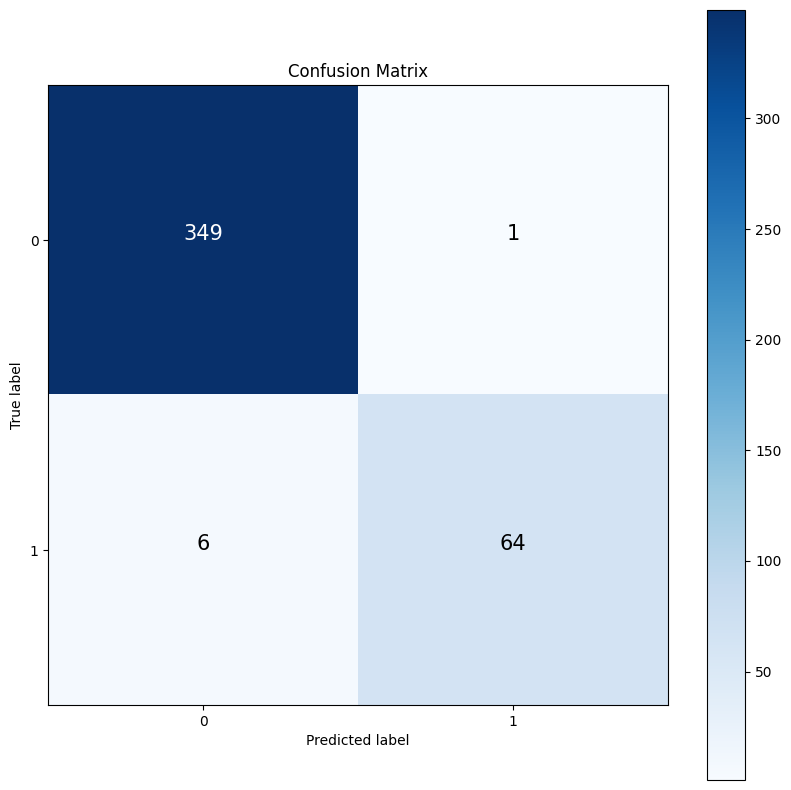

In [ ]:
#Confusion Matrix for Baseline Model
make_confusion_matrix(y_test, y_pred)

Error in generating ROC curve for Normal. Dataset lacks enough examples.


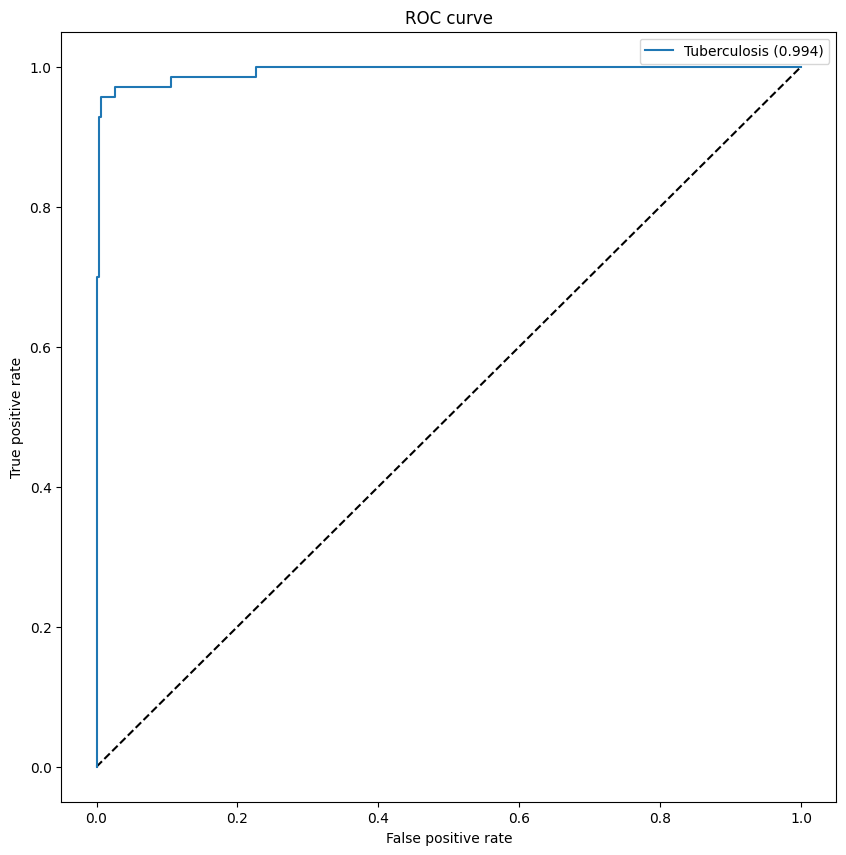

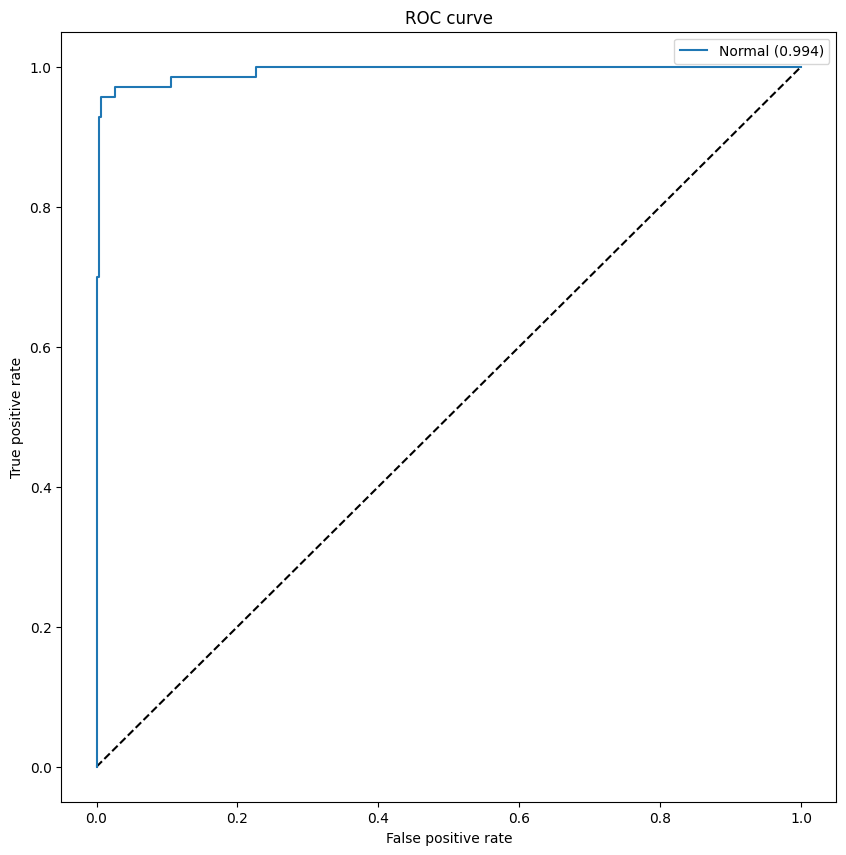

In [ ]:
#ROC Curve Visualization
label = ['Normal']
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)
auc_rocs_1 = get_roc_curve(label, predicted_vals, test_generator)

In [ ]:
#Plotting Val Loss + Accuracy
def plot_training_history(history, metrics):
    n = len(metrics)
    rows = (n + 1) // 2

    plt.figure(figsize=(10, rows * 4))

    for i, metric in enumerate(metrics):
        plt.subplot(rows, 2, i + 1)

        train_metric = history.history.get(metric)
        val_metric = history.history.get(f'val_{metric}')

        if train_metric is None or val_metric is None:
            print(f"Warning: '{metric}' or 'val_{metric}' not found in history. Skipping.")
            continue

        plt.plot(train_metric, label=f'Train {metric.capitalize()}')
        plt.plot(val_metric, label=f'Val {metric.capitalize()}')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

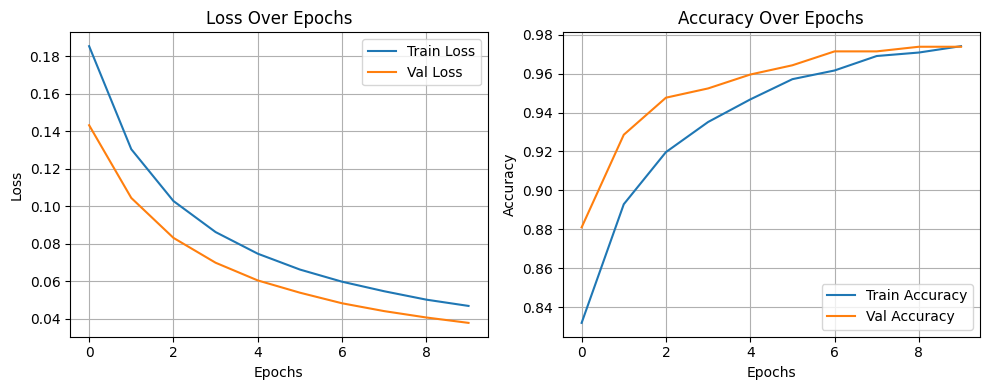

In [ ]:
plot_training_history(history,['loss', 'accuracy'])

**Testing the Baseline Model on Unseen Dataset 1 - Shenzhen**

In [ ]:
path2 = kagglehub.dataset_download("jtiptj/chest-xray-pneumoniacovid19tuberculosis")

Using Colab cache for faster access to the 'chest-xray-pneumoniacovid19tuberculosis' dataset.


In [ ]:
path2

'/kaggle/input/chest-xray-pneumoniacovid19tuberculosis'

In [ ]:
IMG_SIZE = 224
COLOR_MODE = "grayscale"
THRESH = 0.70
BATCH_SIZE = 32
RESCALE = None
PREPROCESS = None

tb_base = "/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train/TURBERCULOSIS"
normal_base = "/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train/NORMAL/"

rows = []
#Generating Dir for Testing of Unseen Data
if os.path.isdir(tb_base):
    for f in os.listdir(tb_base):
        if f.lower().endswith((".jpeg", ".jpg", ".png")):
            rows.append({"filepath": os.path.join(tb_base, f), "label": 1})

if os.path.isdir(normal_base):
    for f in os.listdir(normal_base):
        if f.lower().endswith((".jpeg", ".jpg", ".png")):
            rows.append({"filepath": os.path.join(normal_base, f), "label": 0})

df = pd.DataFrame(rows).reset_index(drop=True)
if df.empty:
    raise RuntimeError("No images found. Check your paths.")

print(f"Total images: {len(df)}   (positives={df['label'].sum()}, negatives={len(df)-df['label'].sum()})")

def load_one(path):
    img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE), color_mode=COLOR_MODE)
    arr = image.img_to_array(img)  # (H, W, C)
    if RESCALE is not None:
        arr = arr * RESCALE
    if PREPROCESS is not None:
        arr = PREPROCESS(np.expand_dims(arr, 0))[0]
    return arr

X = np.stack([load_one(p) for p in df["filepath"].values], axis=0)
y_true = df["label"].values.astype(int)

if COLOR_MODE == "grayscale" and X.shape[-1] == 1:
    pass

Total images: 1991   (positives=650, negatives=1341)



== Metrics @ threshold===
Accuracy:            75.49%
Balanced Accuracy:   62.50%
F1-score:            0.4005
MCC:                 0.4264
Brier score:         0.0512
ROC AUC:             0.9832
PR AUC (AP):         0.9755

Classification Report:
              precision    recall  f1-score   support

           0     0.7334    0.9993    0.8460      1341
           1     0.9939    0.2508    0.4005       650

    accuracy                         0.7549      1991
   macro avg     0.8637    0.6250    0.6232      1991
weighted avg     0.8185    0.7549    0.7005      1991



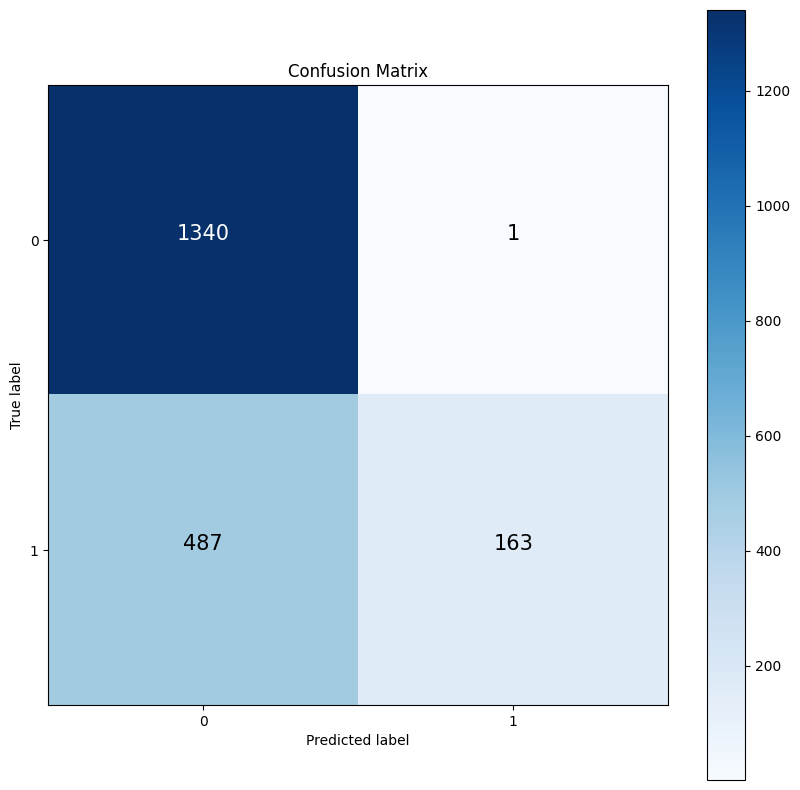

In [ ]:
#This is for unseen Dataset - Shenzhen
y_scores = model1.predict(X, batch_size=BATCH_SIZE, verbose=0).ravel()
y_pred = (y_scores >= 0.9).astype(int)
acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, zero_division=0)
mcc = matthews_corrcoef(y_true, y_pred) if len(np.unique(y_true)) == 2 else np.nan
brier = brier_score_loss(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)  # PR AUC

print(f"\n== Metrics @ threshold===")
print(f"Accuracy:            {acc*100:.2f}%")
print(f"Balanced Accuracy:   {bacc*100:.2f}%")
print(f"F1-score:            {f1:.4f}")
print(f"MCC:                 {mcc:.4f}")
print(f"Brier score:         {brier:.4f}")
print(f"ROC AUC:             {auc:.4f}")
print(f"PR AUC (AP):         {ap:.4f}")

#Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

#Confusion Matrix
make_confusion_matrix(y_true, y_pred)

**Testing the Baseline Model on Unseen Dataset 2 - Pakistan**

In [ ]:
#Using Unseen Dataset 2 from Pakistan
path4 = kagglehub.dataset_download("yasserhessein/tuberculosis-chest-x-rays-images")

100%|██████████| 26.3M/26.3M [00:00<00:00, 138MB/s] 

Extracting files...


In [ ]:
path4

'/root/.cache/kagglehub/datasets/yasserhessein/tuberculosis-chest-x-rays-images/versions/2'

In [ ]:
#Checking Data base structure
import os
data_base = f"{path4}/Dataset of Tuberculosis Chest X-rays Images/Normal Chest X-rays"

if os.path.isdir(data_base):
    print("Listing a few files from the directory:")
    for f in os.listdir(data_base)[:5]:
        print(f)

Listing a few files from the directory:
others (237).jpg
others (53).jpg
others (345).jpg
others (417).jpg
others (218).jpg


In [ ]:
#Same code from processing Unseen Dataset 1
IMG_SIZE = 224
COLOR_MODE = "grayscale"
THRESH = 0.70
BATCH_SIZE = 32
RESCALE = None
PREPROCESS = None

tb_base = f"{path4}/Dataset of Tuberculosis Chest X-rays Images/TB Chest X-rays"
normal_base = f"{path4}/Dataset of Tuberculosis Chest X-rays Images/Normal Chest X-rays/"

rows = []

if os.path.isdir(tb_base):
    for f in os.listdir(tb_base):
        if f.lower().endswith((".jpeg", ".jpg", ".png")):
            rows.append({"filepath": os.path.join(tb_base, f), "label": 1})

if os.path.isdir(normal_base):
    for f in os.listdir(normal_base):
        if f.lower().endswith((".jpeg", ".jpg", ".png")):
            rows.append({"filepath": os.path.join(normal_base, f), "label": 0})

df = pd.DataFrame(rows).reset_index(drop=True)
if df.empty:
    raise RuntimeError("No images found. Check your paths.")

print(f"Total images: {len(df)}   (positives={df['label'].sum()}, negatives={len(df)-df['label'].sum()})")


# Stack all images into a single array for prediction
X = np.stack([load_one(p) for p in df["filepath"].values], axis=0)
y_true = df["label"].values.astype(int)

if COLOR_MODE == "grayscale" and X.shape[-1] == 1:
    pass

Total images: 3008   (positives=2494, negatives=514)



== Metrics @ threshold===
Accuracy:            59.77%
Balanced Accuracy:   74.82%
F1-score:            0.6817
MCC:                 0.3768
Brier score:         0.2580
ROC AUC:             0.8794
PR AUC (AP):         0.9728

Classification Report:
              precision    recall  f1-score   support

           0     0.2953    0.9767    0.4535       514
           1     0.9908    0.5196    0.6817      2494

    accuracy                         0.5977      3008
   macro avg     0.6431    0.7482    0.5676      3008
weighted avg     0.8720    0.5977    0.6427      3008



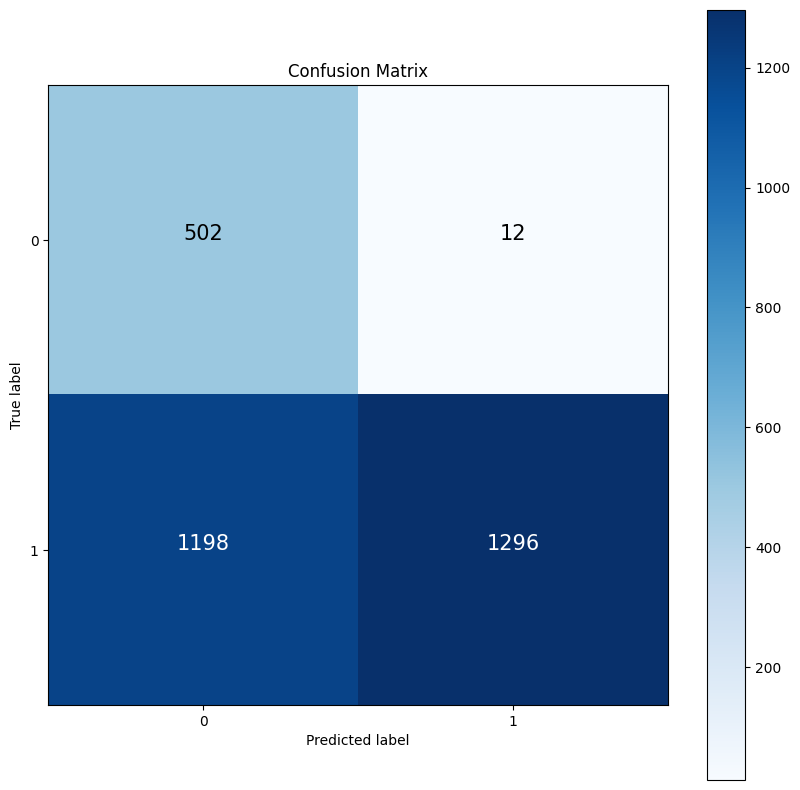

In [ ]:
# Testing Baseline Model Performance on Unseen Dataset 2
y_scores = model1.predict(X, batch_size=BATCH_SIZE, verbose=0).ravel()
y_pred = (y_scores >= 0.5).astype(int)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, zero_division=0)
mcc = matthews_corrcoef(y_true, y_pred) if len(np.unique(y_true)) == 2 else np.nan
brier = brier_score_loss(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)  # PR AUC

print(f"\n== Metrics @ threshold===")
print(f"Accuracy:            {acc*100:.2f}%")
print(f"Balanced Accuracy:   {bacc*100:.2f}%")
print(f"F1-score:            {f1:.4f}")
print(f"MCC:                 {mcc:.4f}")
print(f"Brier score:         {brier:.4f}")
print(f"ROC AUC:             {auc:.4f}")
print(f"PR AUC (AP):         {ap:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

make_confusion_matrix(y_true, y_pred)

**Domain Generalization Model**


---


Implementing MixStyle + Multi-level Augmentation

In [ ]:
#1. Implementation of MixStyle Approach - Refer to paper by Zhou et.al (2021)
class MixStyle(layers.Layer):
    def __init__(self, p=0.5, alpha=0.3, **kwargs):
        super().__init__(**kwargs)
        self.p = float(p)
        self.alpha = float(alpha)

    def call(self, x, training=None):
        if training is None:
            training = tf.keras.backend.learning_phase()

        def maybe_apply_mix():
            B = tf.shape(x)[0]

            def do_mix_logic():
                # This is the original mixing logic
                C = tf.shape(x)[-1]
                x_flat = tf.reshape(x, [B, -1, C])
                mu = tf.reduce_mean(x_flat, axis=1, keepdims=True)
                var = tf.math.reduce_variance(x_flat, axis=1, keepdims=True)
                sigma = tf.sqrt(var + 1e-5)

                idx = tf.random.shuffle(tf.range(B))
                mu2, sigma2 = tf.gather(mu, idx), tf.gather(sigma, idx)

                lam = tf.random.uniform([B, 1, C], 0.0, 1.0)
                lam = tf.clip_by_value(self.alpha * lam + (1.0 - self.alpha) * (1.0 - lam), 0.0, 1.0)

                mu_mix = lam * mu + (1.0 - lam) * mu2
                sigma_mix = lam * sigma + (1.0 - lam) * sigma2

                x_norm = (x_flat - mu) / sigma
                x_mixed = x_norm * sigma_mix + mu_mix
                return tf.reshape(x_mixed, tf.shape(x))
            mixed_x = tf.cond(tf.less(tf.random.uniform([], 0.0, 1.0), self.p), do_mix_logic, lambda: x)
            return mixed_x

        final_x = tf.cond(tf.less(tf.shape(x)[0], 2), lambda: x, maybe_apply_mix)

        # Apply everything only during training
        return tf.cond(tf.cast(training, tf.bool), lambda: final_x, lambda: x)

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        cfg = super().get_config()
        cfg.update({'p': self.p, 'alpha': self.alpha})
        return cfg

In [ ]:
#2. Multi-Layer Augmentation
augmentation_layer = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    layers.RandomContrast(0.1),
    layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.08)),
    # This is the ONLY normalization step, applied last
    layers.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229**2, 0.224**2, 0.225**2]),
], name="augmentation_layer")

In [ ]:
#3. Weighted Loss function BCE
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
        loss = -(pos_weights * y_true * tf.math.log(y_pred) +
                 neg_weights * (1 - y_true) * tf.math.log(1 - y_pred))
        return tf.reduce_mean(loss)
    return weighted_loss

In [ ]:
#4 Building the Enhanced model
def build_densenet_model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_image")
    x = augmentation_layer(inputs)

    base = DenseNet121(weights="imagenet", include_top=False, input_tensor=x)
    base.trainable = False # Start with the base frozen

    feat = base.output
    feat = MixStyle(p=0.5, alpha=0.3, name="mixstyle")(feat)

    gap = layers.GlobalAveragePooling2D()(feat)
    gmp = layers.GlobalMaxPooling2D()(feat)
    x = layers.Concatenate()([gap, gmp])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inputs, outputs)
    return model

In [ ]:
model = build_densenet_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation_layer  │ (None, 224, 224,  │          0 │ input_image[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ augmentation_lay… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b

 Total params: 7,571,521 (28.88 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 7,042,112 (26.86 MB)

In [ ]:
# 5. TRAINING AND FINE-TUNING
if not df.empty:
    model = build_densenet_model()
    checkpoint = ModelCheckpoint("best_model.weights.h5", monitor="val_auroc", mode="max", save_best_only=True, save_weights_only=True)

    # Phase 1: TRAIN THE HEAD
    print("\n--- PHASE 1: Training the classifier head ---")
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(1e-3, weight_decay=1e-4),
        loss=get_weighted_loss(pos_weights, neg_weights),
        metrics=["accuracy", tf.keras.metrics.AUC(name="auroc")]
    )

    history_head = model.fit(
        train_generator,
        epochs=15,
        validation_data=val_generator,
        callbacks=[checkpoint, RLR, ES]
    )


--- PHASE 1: Training the classifier head ---
Epoch 1/15
420/420 ━━━━━━━━━━━━━━━━━━━━ 78s 133ms/step - accuracy: 0.7069 - auroc: 0.8476 - loss: 0.2193 - val_accuracy: 0.9690 - val_auroc: 0.9949 - val_loss: 0.0740 - learning_rate: 0.0010
Epoch 2/15
420/420 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - accuracy: 0.8405 - auroc: 0.9253 - loss: 0.1472 - val_accuracy: 0.9738 - val_auroc: 0.9991 - val_loss: 0.0625 - learning_rate: 0.0010
Epoch 3/15
420/420 ━━━━━━━━━━━━━━━━━━━━ 47s 111ms/step - accuracy: 0.8743 - auroc: 0.9479 - loss: 0.1298 - val_accuracy: 0.9762 - val_auroc: 0.9984 - val_loss: 0.0640 - learning_rate: 0.0010
Epoch 4/15
420/420 ━━━━━━━━━━━━━━━━━━━━ 46s 110ms/step - accuracy: 0.8855 - auroc: 0.9524 - loss: 0.1234 - val_accuracy: 0.9738 - val_auroc: 0.9955 - val_loss: 0.0757 - learning_rate: 0.0010
Epoch 5/15
420/420 ━━━━━━━━━━━━━━━━━━━━ 47s 111ms/step - accuracy: 0.8848 - auroc: 0.9602 - loss: 0.1195 - val_accuracy: 0.9643 - val_auroc: 0.9963 - val_loss: 0.0711 - learning_rate: 0.0010

In [ ]:
# Load the best weights
model.load_weights("best_model.weights.h5")

# PHASE 2: Further fine-tuning of Enhanced model
print("\n--- PHASE 2: Fine-tuning the full model ---")
model.layers[1].trainable = True

#Compiling the model for second training
model.compile(
  optimizer=tf.keras.optimizers.AdamW(1e-5, weight_decay=1e-5), # Lower LR
  loss=get_weighted_loss(pos_weights, neg_weights),
  metrics=["accuracy", tf.keras.metrics.AUC(name="auroc")]
)

history_finetune = model.fit(
  train_generator,
  epochs=15,
  validation_data=val_generator,
  callbacks=[RLR, ES, checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



--- PHASE 2: Fine-tuning the full model ---
Epoch 1/15
420/420 ━━━━━━━━━━━━━━━━━━━━ 71s 128ms/step - accuracy: 0.8684 - auroc: 0.9428 - loss: 0.1325 - val_accuracy: 0.9786 - val_auroc: 0.9993 - val_loss: 0.0605 - learning_rate: 1.0000e-05
Epoch 2/15
420/420 ━━━━━━━━━━━━━━━━━━━━ 46s 109ms/step - accuracy: 0.8585 - auroc: 0.9426 - loss: 0.1308 - val_accuracy: 0.9810 - val_auroc: 0.9990 - val_loss: 0.0618 - learning_rate: 1.0000e-05
Epoch 3/15
420/420 ━━━━━━━━━━━━━━━━━━━━ 49s 116ms/step - accuracy: 0.8689 - auroc: 0.9352 - loss: 0.1400 - val_accuracy: 0.9786 - val_auroc: 0.9991 - val_loss: 0.0615 - learning_rate: 1.0000e-05
Epoch 4/15
420/420 ━━━━━━━━━━━━━━━━━━━━ 49s 117ms/step - accuracy: 0.8857 - auroc: 0.9536 - loss: 0.1181 - val_accuracy: 0.9810 - val_auroc: 0.9993 - val_loss: 0.0601 - learning_rate: 1.0000e-05
Epoch 5/15
420/420 ━━━━━━━━━━━━━━━━━━━━ 43s 103ms/step - accuracy: 0.8791 - auroc: 0.9473 - loss: 0.1255 - val_accuracy: 0.9810 - val_auroc: 0.9990 - val_loss: 0.0604 - learni

In [ ]:
# 6. Evaluation of Enhanced Model
print("\n--- Evaluating final model on the test set ---")
# Load best weights
model.load_weights("best_model.weights.h5")
pred_proba = model.predict(test_generator, verbose=1).ravel()
y_pred = (pred_proba >= 0.6).astype(int)
y_true = test_df['Tuberculosis']

print("\nTest Set ROC AUC Score: ", roc_auc_score(y_true, pred_proba))
print("Test Set Accuracy: ", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['Normal', 'Tuberculosis']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)


--- Evaluating final model on the test set ---
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step

Test Set ROC AUC Score:  0.9986530612244898
Test Set Accuracy:  0.9809523809523809

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.98      0.99       350
Tuberculosis       0.91      0.99      0.95        70

    accuracy                           0.98       420
   macro avg       0.95      0.98      0.97       420
weighted avg       0.98      0.98      0.98       420



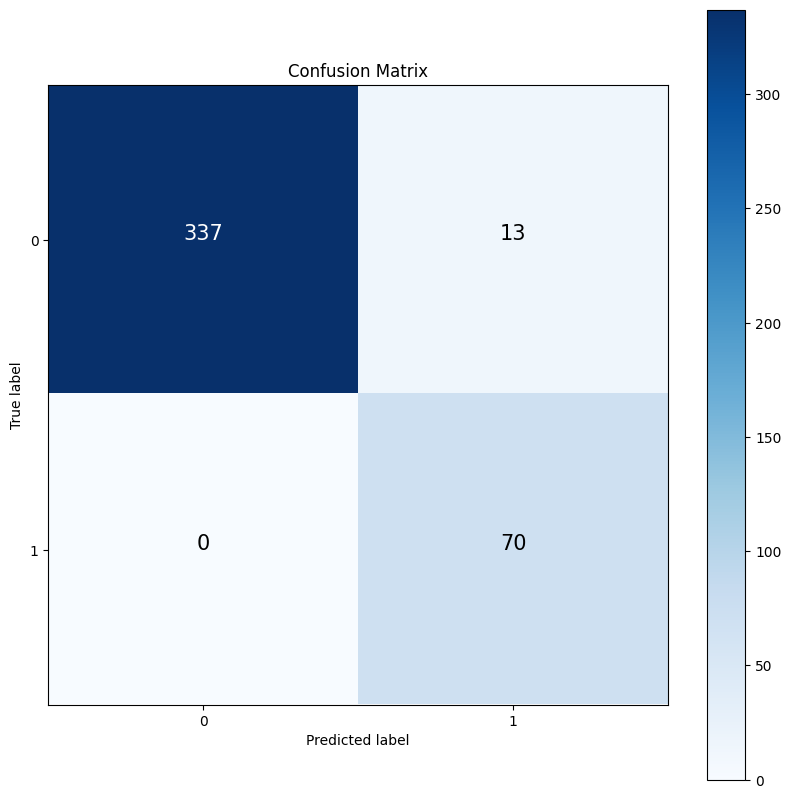

In [ ]:
make_confusion_matrix(y_true, y_pred)

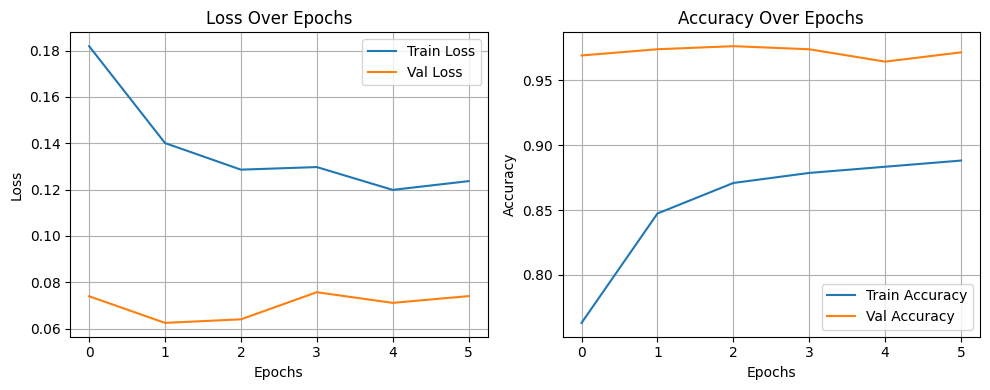

In [ ]:
#Training history for Phase 1
plot_training_history(history_head,['loss', 'accuracy'])

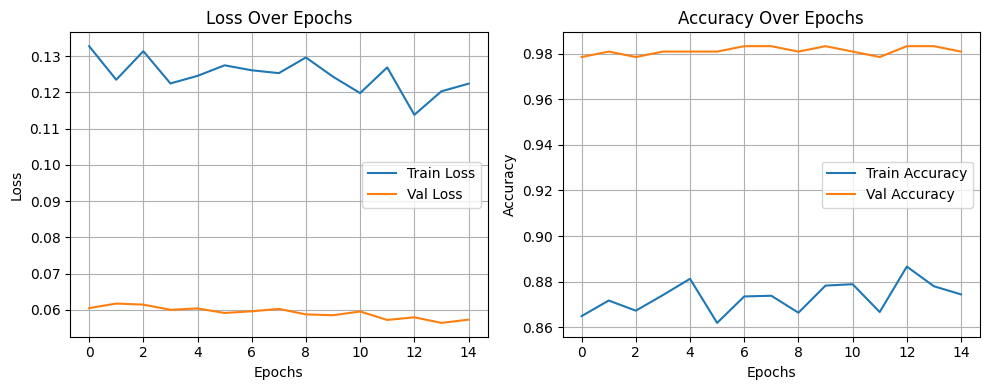

In [ ]:
#Training History for Phase 2
plot_training_history(history_finetune,['loss', 'accuracy'])

**Testing Enhanced model on Unseen Dataset 1 - Shenzhen**


== Metrics @ threshold===
Accuracy:            82.17%
Balanced Accuracy:   83.28%
F1-score:            0.7600
MCC:                 0.6331
Brier score:         0.2658
ROC AUC:             0.9212
PR AUC (AP):         0.8716

Classification Report:
              precision    recall  f1-score   support

           0     0.9243    0.8009    0.8582      1341
           1     0.6779    0.8646    0.7600       650

    accuracy                         0.8217      1991
   macro avg     0.8011    0.8328    0.8091      1991
weighted avg     0.8438    0.8217    0.8261      1991



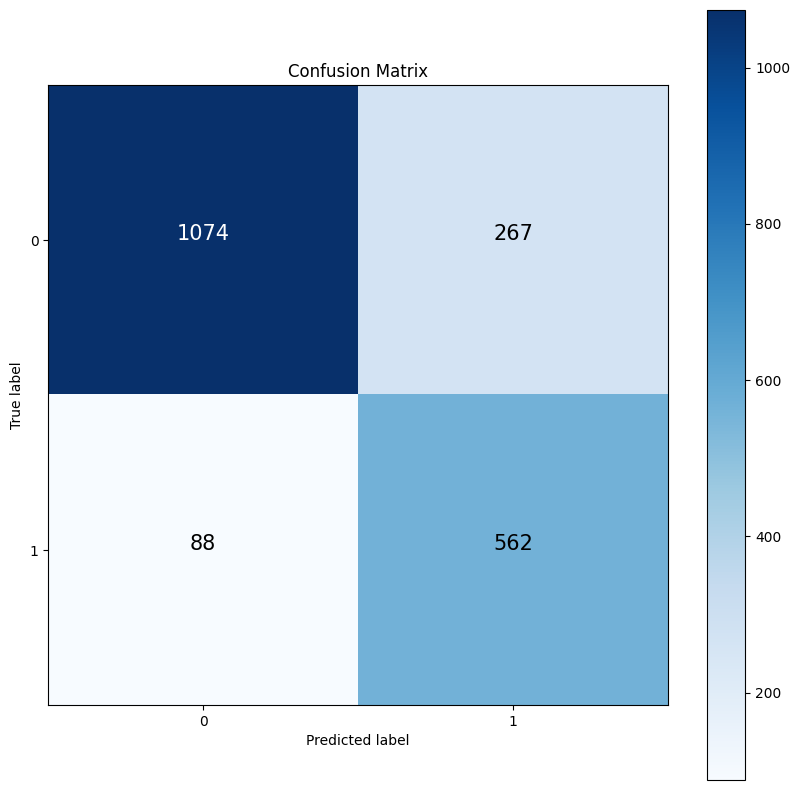

In [ ]:
# Predict probabilities
y_scores = model.predict(X, batch_size=BATCH_SIZE, verbose=0).ravel()
y_pred = (y_scores >= 0.9).astype(int)
acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, zero_division=0)
mcc = matthews_corrcoef(y_true, y_pred) if len(np.unique(y_true)) == 2 else np.nan
brier = brier_score_loss(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)  # PR AUC

print(f"\n== Metrics @ threshold===")
print(f"Accuracy:            {acc*100:.2f}%")
print(f"Balanced Accuracy:   {bacc*100:.2f}%")
print(f"F1-score:            {f1:.4f}")
print(f"MCC:                 {mcc:.4f}")
print(f"Brier score:         {brier:.4f}")
print(f"ROC AUC:             {auc:.4f}")
print(f"PR AUC (AP):         {ap:.4f}")

#Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

#Confusion Matrix
make_confusion_matrix(y_true, y_pred)

**Testing Enhanced model on Unseen Dataset 2 - Pakistan**


== Metrics @ threshold===
Accuracy:            77.13%
Balanced Accuracy:   62.73%
F1-score:            0.8598
MCC:                 0.2407
Brier score:         0.1583
ROC AUC:             0.7447
PR AUC (AP):         0.9367

Classification Report:
              precision    recall  f1-score   support

           0     0.3535    0.4086    0.3791       514
           1     0.8741    0.8460    0.8598      2494

    accuracy                         0.7713      3008
   macro avg     0.6138    0.6273    0.6194      3008
weighted avg     0.7851    0.7713    0.7777      3008



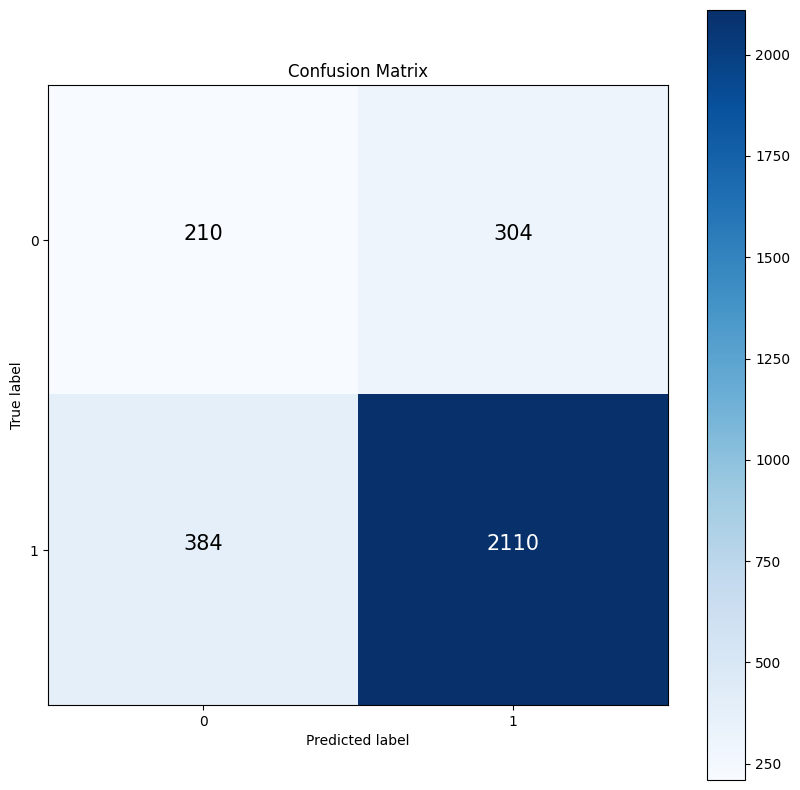

In [ ]:
# Predict probabilities for Unseen Dataset 2 - Pakistan
y_scores = model.predict(X, batch_size=BATCH_SIZE, verbose=0).ravel()
y_pred = (y_scores >= 0.3).astype(int)
acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, zero_division=0)
mcc = matthews_corrcoef(y_true, y_pred) if len(np.unique(y_true)) == 2 else np.nan
brier = brier_score_loss(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)  # PR AUC

print(f"\n== Metrics @ threshold===")
print(f"Accuracy:            {acc*100:.2f}%")
print(f"Balanced Accuracy:   {bacc*100:.2f}%")
print(f"F1-score:            {f1:.4f}")
print(f"MCC:                 {mcc:.4f}")
print(f"Brier score:         {brier:.4f}")
print(f"ROC AUC:             {auc:.4f}")
print(f"PR AUC (AP):         {ap:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

make_confusion_matrix(y_true, y_pred)

In [214]:
from google.colab import files
files.download(df['filepath'][3003])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [213]:
df['filepath'][3003]

'/root/.cache/kagglehub/datasets/yasserhessein/tuberculosis-chest-x-rays-images/versions/2/Dataset of Tuberculosis Chest X-rays Images/Normal Chest X-rays/others (110).jpg'

In [203]:
#Web-application
import gradio as gr, numpy as np
from tensorflow.keras.utils import img_to_array

def predict(im):
    x = np.expand_dims(img_to_array(im.convert("RGB").resize((224,224))), 0)
    y = model1.predict(x)
    if y.ndim==2 and y.shape[1]==1:
        p = float(y[0,0]);  p = 1/(1+np.exp(-p)) if not (0<=p<=1) else p
        probs = {"Normal": 1-p, "TB": p}
    else:
        p = np.exp(y[0]-y[0].max()); p /= p.sum()
        probs = {f"Class {i}": float(p[i]) for i in range(len(p))}
    label = max(probs, key=probs.get)
    return label, probs

gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload chest X-ray"),
    outputs=[gr.Label(label="Prediction"), gr.JSON(label="Probabilities")],
    title=" 🫁TB CXR Classifier"
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0c887664ff526e2501.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
